# Test new features with regression problem
## Kaggle Rossmann store
This demo is based on **Rossmann Store Sales**  
https://www.kaggle.com/c/otto-group-product-classification-challenge

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline

In [3]:
# read dataset
ross = pd.read_csv('rossmann_train.csv')
store = pd.read_csv('rossmann_store.csv')

# simple feature engineering
ross = ross[ross['Open'] != 0]
ross = ross.merge(store, on='Store', how='left')

ross['Date'] = pd.to_datetime(ross['Date'])
ross['year'] = ross.Date.apply(lambda x : x.year)
ross['month'] = ross.Date.apply(lambda x : x.month)
ross['weekofyear'] = ross.Date.apply(lambda x: x.weekofyear)
ross.drop(['Date'], axis=1, inplace=True)

ross = pd.get_dummies(ross, columns=['StateHoliday', 'StoreType', 'Assortment'])

ross_features = ['DayOfWeek', 'SchoolHoliday', 'month', 'weekofyear', 'StateHoliday_a', 'StateHoliday_b',
                 'StateHoliday_c', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 
                 'Assortment_a', 'Assortment_b','Assortment_c']

# build simple random forest regressor
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 50, n_jobs=4)
%time rf.fit(ross[ross_features], ross['Sales'])

/Users/saucecat/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


CPU times: user 1min 26s, sys: 1.23 s, total: 1min 27s
Wall time: 23.8 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# testing PDPbox new features

In [4]:
import sys
sys.path.insert(0, '../../pdpbox/')

import pdp as pdp_test
from pdpbox import pdp

## test joblib and pickle

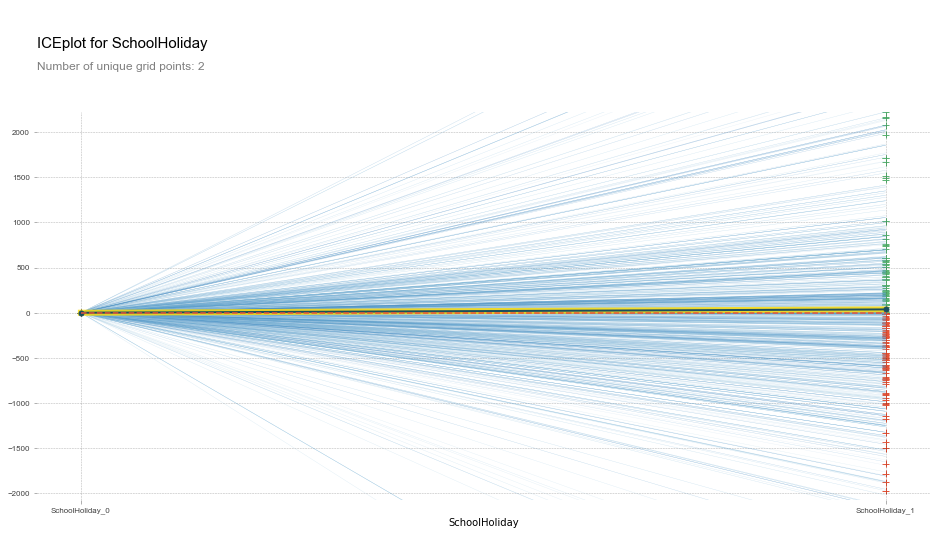

In [5]:
pdp_SchoolHoliday = pdp_test.pdp_isolate(rf, ross[ross_features], 'SchoolHoliday')
pdp_test.pdp_plot(pdp_SchoolHoliday, 'SchoolHoliday', plot_org_pts=True, plot_lines=True, frac_to_plot=1000)

In [6]:
from sklearn.externals import joblib

joblib.dump(pdp_SchoolHoliday, 'pdp_SchoolHoliday.pkl', compress=True)
pdp_SchoolHoliday = joblib.load('pdp_SchoolHoliday.pkl')

In [7]:
import pickle

pickle.dump(pdp_SchoolHoliday, open("pdp_SchoolHoliday.pickle", "wb"))
pdp_SchoolHoliday = pickle.load(open("pdp_SchoolHoliday.pickle", "r"))

## test parallel processing

In [8]:
%time pdp_weekofyear = pdp_test.pdp_isolate(rf, ross[ross_features], 'weekofyear')

CPU times: user 31.7 s, sys: 2.82 s, total: 34.5 s
Wall time: 12.9 s


In [9]:
%time pdp_weekofyear = pdp_test.pdp_isolate(rf, ross[ross_features], 'weekofyear', n_jobs=4)

CPU times: user 5.08 s, sys: 2.05 s, total: 7.13 s
Wall time: 10.3 s


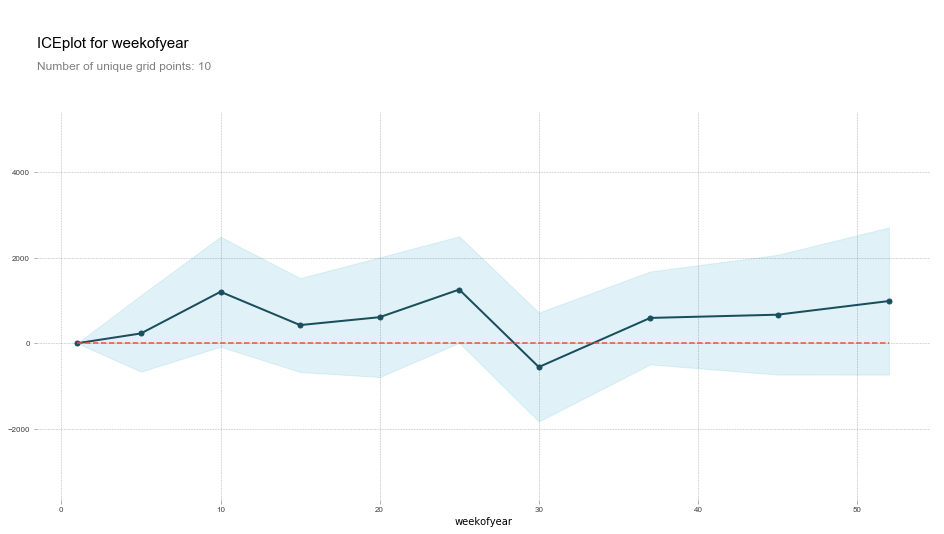

In [10]:
pdp_test.pdp_plot(pdp_weekofyear, 'weekofyear')

#### compare with the original one

In [11]:
%time pdp_weekofyear_old = pdp.pdp_isolate(rf, ross[ross_features], 'weekofyear')

CPU times: user 34.5 s, sys: 3.81 s, total: 38.3 s
Wall time: 15.1 s


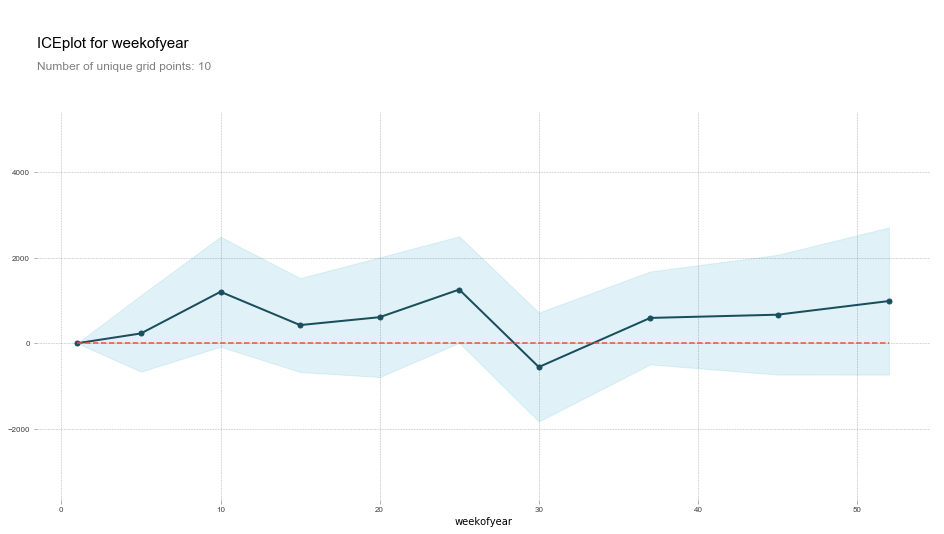

In [12]:
pdp.pdp_plot(pdp_weekofyear, 'weekofyear')

## test parallel processing: interation plot

In [13]:
%%time
inter_rf = pdp_test.pdp_interact(rf, ross[ross_features], 
                                 [['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d'], 'weekofyear'], 
                                 num_grid_points=[10, 10])

CPU times: user 2min 38s, sys: 20.6 s, total: 2min 58s
Wall time: 1min 17s


In [14]:
%%time
inter_rf = pdp_test.pdp_interact(rf, ross[ross_features], 
                                 [['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d'], 'weekofyear'], 
                                 num_grid_points=[10, 10], n_jobs=4)

CPU times: user 20.1 s, sys: 18.5 s, total: 38.6 s
Wall time: 59.7 s


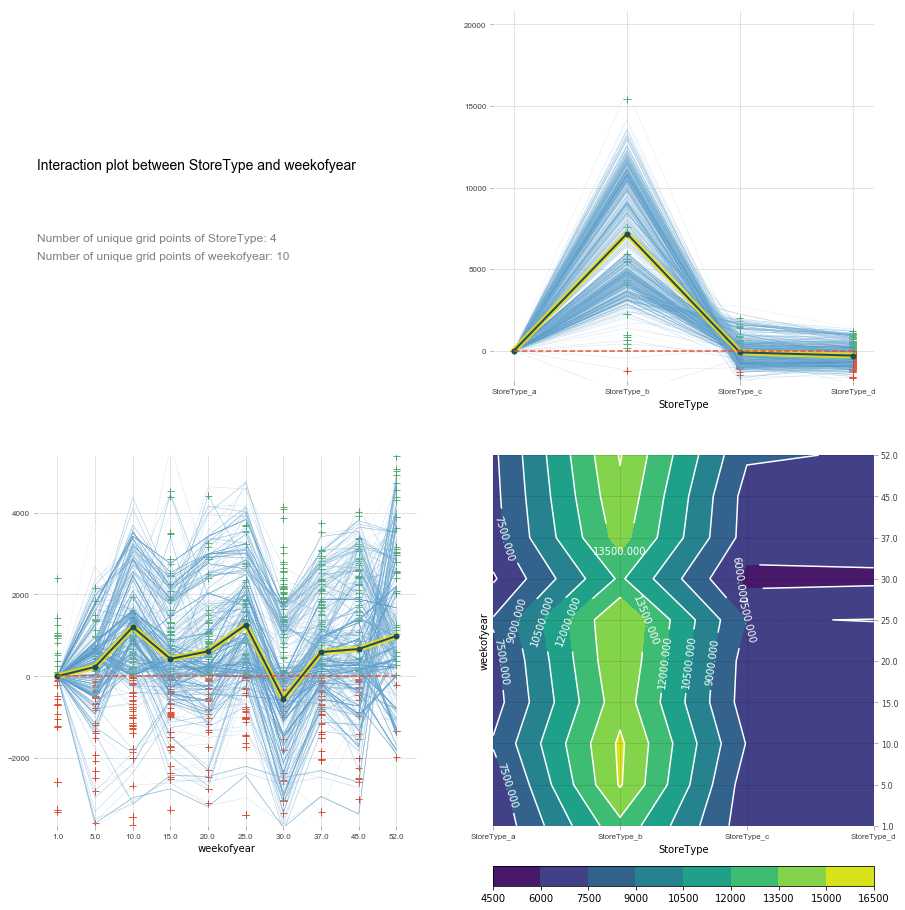

In [15]:
pdp_test.pdp_interact_plot(inter_rf, ['StoreType', 'weekofyear'], 
                           plot_org_pts=True, plot_lines=True, frac_to_plot=1000, x_quantile=True)

#### compare with the original one

In [16]:
%%time
inter_rf = pdp.pdp_interact(rf, ross[ross_features], 
                            [['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d'], 'weekofyear'], 
                            num_grid_points=[10, 10])

CPU times: user 3min 9s, sys: 42.9 s, total: 3min 52s
Wall time: 1min 59s


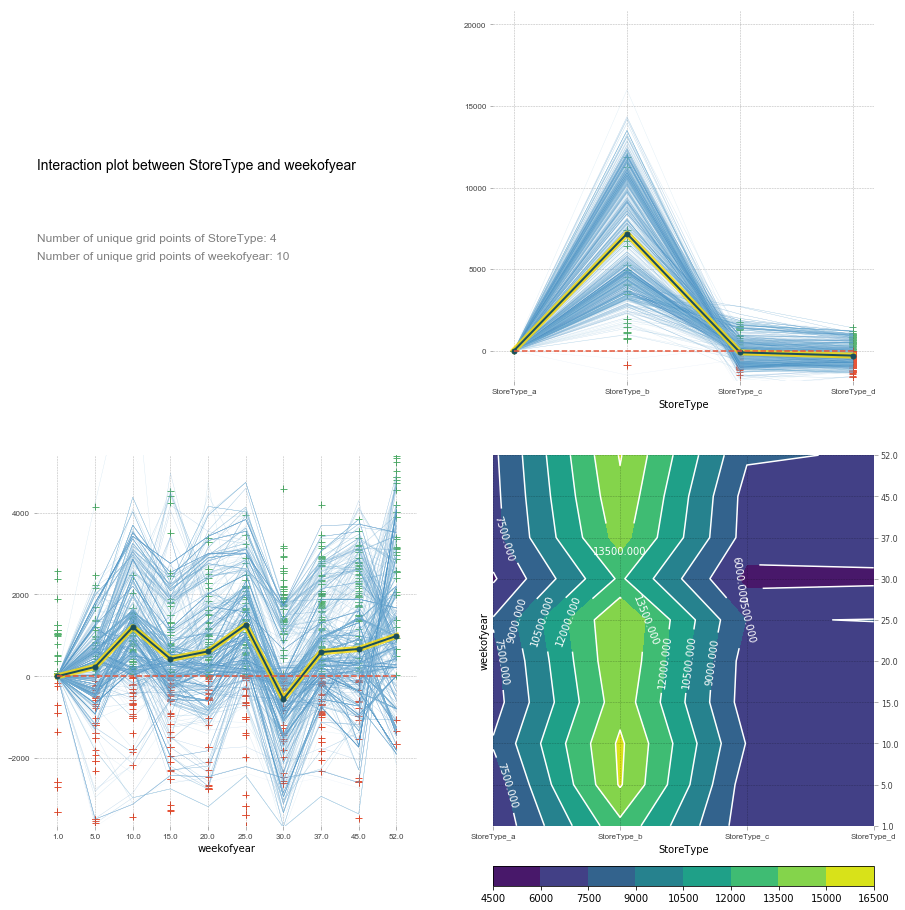

In [17]:
pdp.pdp_interact_plot(inter_rf, ['StoreType', 'weekofyear'], 
                      plot_org_pts=True, plot_lines=True, frac_to_plot=1000, x_quantile=True)